# OptimUS validation
The OptimUS library provides functionality to simulate acoustic wave propagation in unbounded domains with homogeneous scatterers with boundary element methods. This notebook demostrates the accuracy of the OptimUS library by comparing its solutions with the analytical expression for scattering at two concentric spheres.


## Analytical Solution

Let us consider harmonic acoustic wave propagation through the entire three-dimensional space, composed of three homogeneous domains, defined by two concentric spheres. Each domain is denoted by $\Omega_m$, for $m \in \{0,1,2\}$. The domain $\Omega_0$ is the unbounded exterior medium, $\Omega_1$ a bounded domain with $\Omega_2$ inside. There are two material interfaces: $\Gamma_1$ between $\Omega_0$ and $\Omega_1$, which corresponds to the outer sphere, and $\Gamma_2$ between $\Omega_1$ and $\Omega_2$, which corresponds to the inner sphere. The unit normals $\hat{\mathbf{n}}_m$ corresponding to surface $\Gamma_m$ all point towards the exterior. We consider harmonic wave fields with an $e^{-\imath\omega t}$ time dependency and a fixed frequency $f$, where $\omega = 2\pi f$ denotes the angular frequency. Each material domain $\Omega_m$ has a constant density and speed of sound, denoted by $\rho_m$ and $c_m$, respectively. The wavenumber is $k_m = 2\pi f / c_m + \imath \alpha_m$ where $\alpha_m$ denotes the attenuation coefficient that may depend on the frequency. The Helmholtz system:

$$
\begin{aligned}
    \begin{cases}
        -\nabla^2 p_m - k_m^2 p_m = 0, & \text{in } \Omega_m \text{ for } m \in \{0,1,2\}; \\
        p_0 + p_{inc} = p_1, & \text{at } \Gamma_1; \\
        p_1 = p_2, & \text{at } \Gamma_2; \\    
        \frac1{\rho_0} \frac{\partial}{\partial \hat{\mathbf{n}}_1} (p_0 + p_{inc}) = \frac1{\rho_1} \frac{\partial}{\partial \hat{\mathbf{n}}_1} p_1, & \text{at } \Gamma_1; \\
        \frac1{\rho_1} \frac{\partial}{\partial \hat{\mathbf{n}}_2} p_1 = \frac1{\rho_2} \frac{\partial}{\partial \hat{\mathbf{n}}_2} p_2, & \text{at } \Gamma_2; \\
        \lim_{\mathbf{r} \to \infty} |\mathbf{r}| \left(\partial_{|\mathbf{r}|} p_0 - \imath k_0 p_0\right) = 0;         
    \end{cases}
\end{aligned}
$$

models the harmonic wave propagation. The second until fifth equation are the interface conditions stating continuity of the pressure field and the normal particle velocity. The sixth equation is the Sommerfeld radiation condition for outgoing waves.

The analytical solution to this problem is described in:

McNew, J., Lavarello, R. and O’Brien, W.D., 2009. Sound scattering from two concentric fluid spheres. The Journal of the Acoustical Society of America, 125(1), pp.1-4.

## Comparison

We import the OptimUS library and set up the basic parameters for the simulation.

In [1]:
import sys
sys.path.append('..')
import optimus

In [2]:
frequency = 1000
source = optimus.source.create_planewave(frequency, direction=(1,1,0))

In [3]:
material_ext = optimus.material.load_material('air')
materials_int = optimus.material.load_material(('fat', 'bone (cortical)'))
material1, material2 = materials_int

We specify some visualization parameters as well

In [4]:
bounding_box = [-3, 5, -3, 4]
plane_axes = (0,1)
resolution = (250,250)

Now we compute both models as well as the visualization plane. For the analytical model, the number of expansion terms can be specified by the parameter `n_iter` in the `solve` method. Note that we use different formulations for the interior and exterior domains.

In [5]:
planes = list()

import numpy as np
elem_per_wavelength = np.arange(2, 6, 1)
elem_sizes = material_ext.compute_wavelength(frequency) / elem_per_wavelength

for element_size in elem_sizes:
    radii = (1.0, 0.5)
    origins = ((0,0,0), (0,0,0))

    geometry1 = optimus.geometry.shapes.Sphere(radius=radii[0], origin=origins[0], element_size=element_size, label="Outer sphere")
    geometry2 = optimus.geometry.shapes.Sphere(radius=radii[1], origin=origins[1], element_size=element_size, label="Inner sphere")
    geometries = (geometry1, geometry2)
    
    # Build and solve analytical model
    analytical_model = optimus.model.acoustics.AnalyticalTwoSpheres(source, geometries, material_ext, materials_int)
    analytical_model.solve(n_iter=100)
    
    # Build and solve bem model
    # Create interfaces for nested BEM formulation
    mygraph = optimus.geometry.Graph("two_scatterers")
    mygraph.create_exterior_domain(material_ext, source)
    mygraph.create_interface(geometry1, 0, material1)
    mygraph.create_interface(geometry2, 1, material2)
    # Create BEM model
    bem_model = optimus.model.create_nested_model(mygraph, frequency, ["multitrace", "pmchwt"], "mass")
    bem_model.solve()
    
    # Compute analytical fields in the plane plane_axes
    analytical_plane = optimus.postprocess.VisualisePlane(analytical_model)
    analytical_plane.create_computational_grid(
        resolution=resolution,
        bounding_box=bounding_box,
        plane_axes=plane_axes
    )
    analytical_plane.compute_fields()
    
    # Compute bem fields in the plane plane_axes
    bem_plane = optimus.postprocess.VisualisePlane(bem_model)
    bem_plane.create_computational_grid(
        resolution=resolution,
        bounding_box=bounding_box,
        plane_axes=plane_axes
    )
    bem_plane.compute_fields()
    
    # Save visualization planes for future inspections and comparison
    planes.append( (analytical_plane, bem_plane) )

With the planes computed, we can calculate the relative error in both Frobenius and maximum norm.

In [6]:
import numpy as np
from numpy.linalg import norm

In [7]:
frob_rel_error_list = list()
unif_rel_error_list = list()


for (analytical_plane, bem_plane) in map(
    lambda p: (np.real(p[0].total_field_imshow), np.real(p[1].total_field_imshow)),
    planes
):
    diff = np.nan_to_num(analytical_plane - bem_plane)
    
    # Compute frobenius relative error
    frob_rel_error = norm(diff, 'fro') / norm(np.nan_to_num(analytical_plane), 'fro')
    frob_rel_error_list.append(frob_rel_error)
    
    # Compute uniform relative error
    unif_rel_error = norm(diff, np.inf) / norm(np.nan_to_num(analytical_plane), np.inf)
    unif_rel_error_list.append(unif_rel_error)

Now we plot the relative errors against the element size

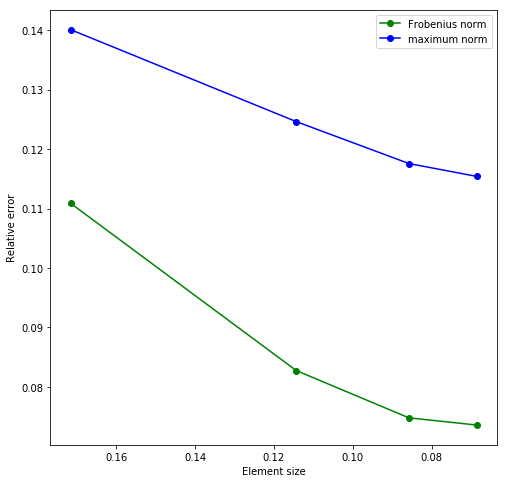

In [8]:
import matplotlib.pyplot as plt

%matplotlib inline

plt.figure(figsize=(8,8))

plt.plot(elem_sizes, frob_rel_error_list, 'go-', label='Frobenius norm')
plt.plot(elem_sizes, unif_rel_error_list, 'bo-', label='maximum norm')

plt.legend()
plt.xlabel('Element size')
plt.ylabel('Relative error')

plt.gca().invert_xaxis()

plt.show()

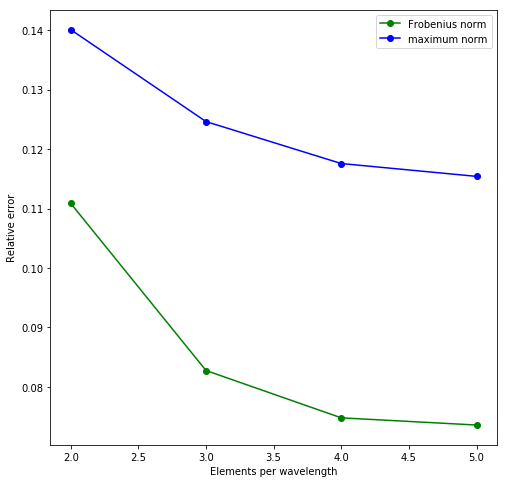

In [11]:
plt.figure(figsize=(8,8))

plt.plot(elem_per_wavelength, frob_rel_error_list, 'go-', label='Frobenius norm')
plt.plot(elem_per_wavelength, unif_rel_error_list, 'bo-', label='maximum norm')

plt.legend()
plt.xlabel('Elements per wavelength')
plt.ylabel('Relative error')

plt.gca()

plt.show()

We now plot the field side by side for visual inspection.

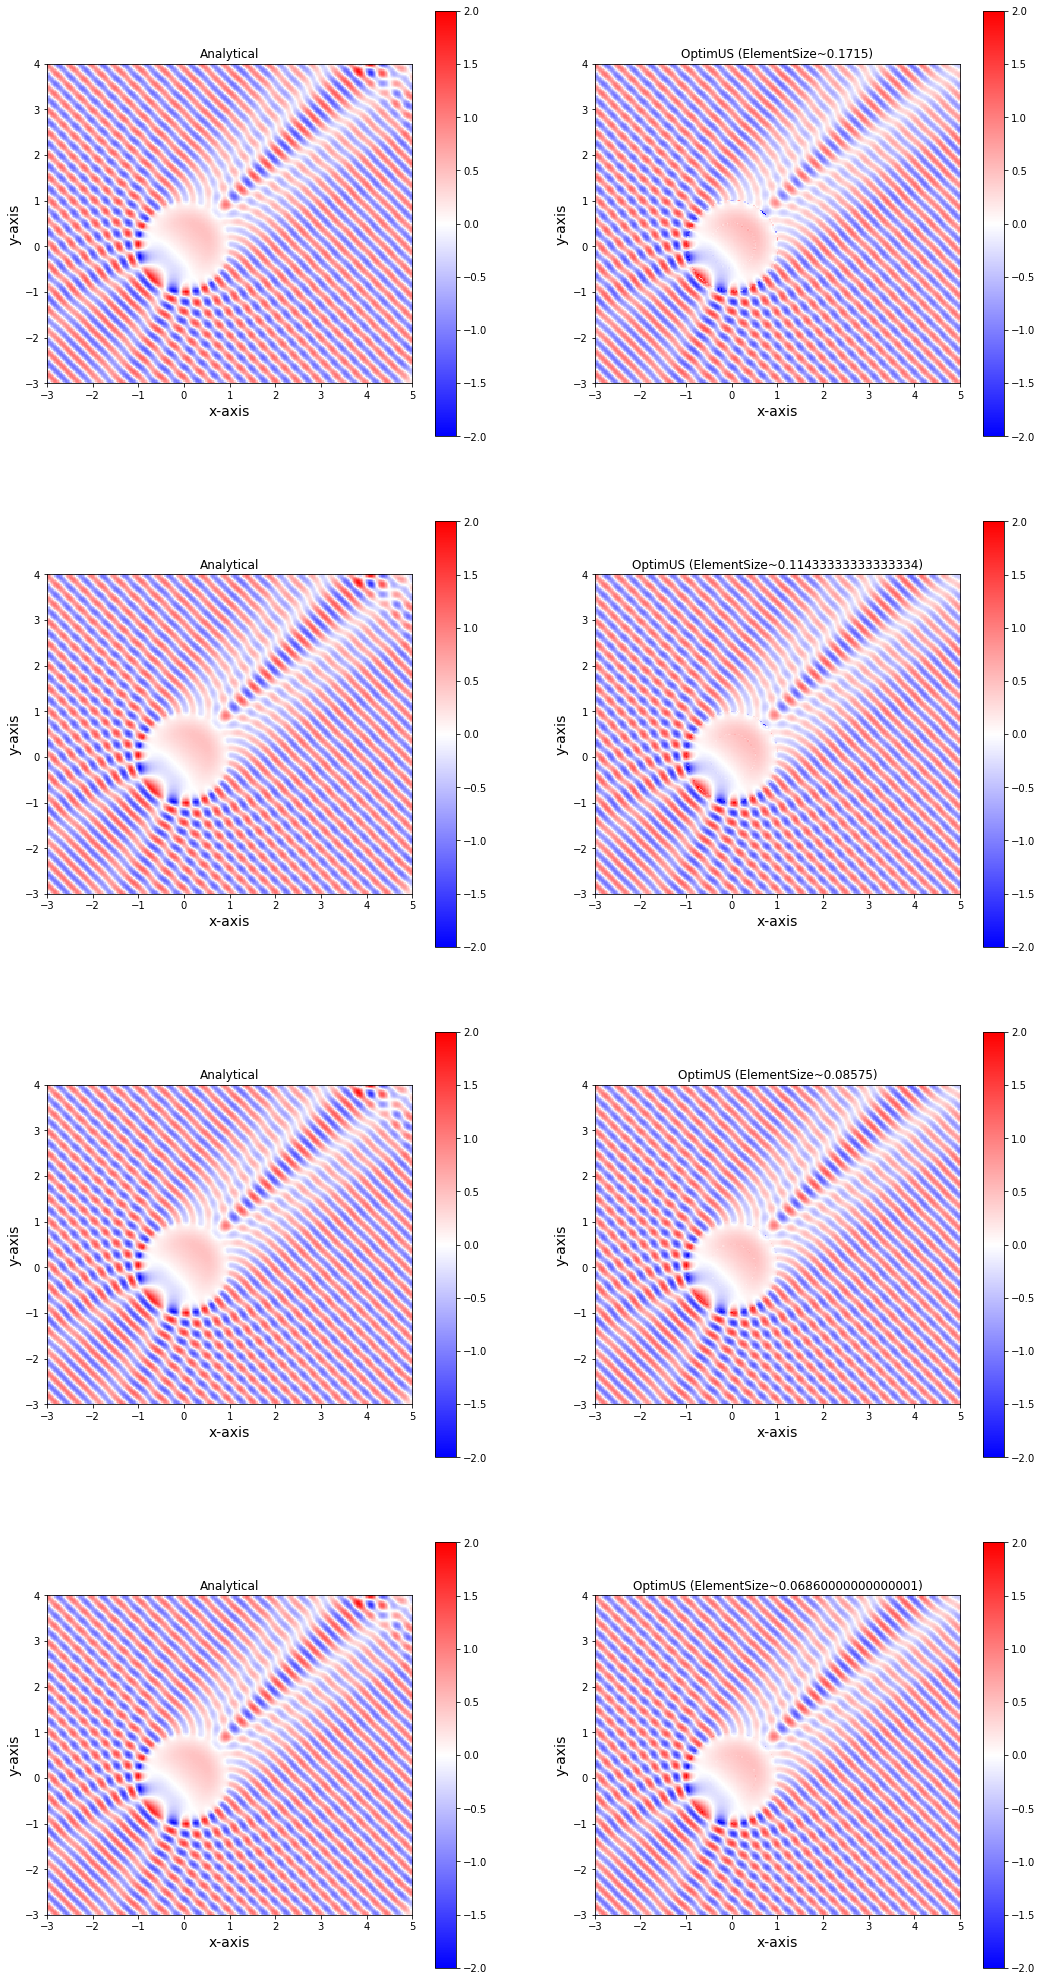

In [10]:
ncols = 2
nrows = len(elem_sizes)

axs = (plt.figure(figsize=(9 * ncols, 9 * nrows)).subplots(nrows=nrows, ncols=2))

plt_info = [
    (
        (axs[i][0], "Analytical", np.real(planes[i][0].total_field_imshow)),
        (axs[i][1], "OptimUS (ElementSize~" + str(n) + ")", np.real(planes[i][1].total_field_imshow))
    )
    for i, n in enumerate(elem_sizes)
]

axis_label = 'xyz'

for each_row in plt_info:
    for (ax, title, data) in each_row:
        ax.set_title(title)
        ax.set_xlabel(axis_label[plane_axes[0]] + '-axis', size='14')
        ax.set_ylabel(axis_label[plane_axes[1]] + '-axis', size='14')
        im = ax.imshow(data,
                       extent=bounding_box,
                       vmin=-2, vmax=2,
                       cmap='bwr')
        ax.figure.colorbar(im, ax=ax)